# Transformer-Based Model for Sentiment Analysis
# Extension: DistilBERT Fine-tuning

This notebook implements a Transformer-based model (DistilBERT) for sentiment analysis and compares its performance with the previously trained models (Dense NN, RNN, LSTM).

**Key Objectives:**
1. Fine-tune a pre-trained DistilBERT model
2. Evaluate performance on the test set
3. Compare with recurrent models
4. Analyze how attention mechanisms differ from recurrent memory

## 1. Setup and Imports

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW

from transformers import DistilBertTokenizer, DistilBertModel
from transformers import get_linear_schedule_with_warmup

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, 
    f1_score, cohen_kappa_score, confusion_matrix,
    classification_report
)

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ All libraries imported successfully")
print(f"✓ PyTorch version: {torch.__version__}")
print(f"✓ CUDA available: {torch.cuda.is_available()}")

✓ All libraries imported successfully
✓ PyTorch version: 2.9.1+cpu
✓ CUDA available: False


## 2. Configuration and Hyperparameters

In [8]:
CONFIG = {
    'model_name': 'distilbert-base-uncased',
    'max_length': 128,
    'num_labels': 2,
    
    # Training
    'batch_size': 16,
    'epochs': 5,
    'learning_rate': 2e-5,
    'warmup_steps': 100,
    'weight_decay': 0.01,
    
    # Fine-tuning strategy
    'freeze_layers': 4,
    
    'data_dir': '../data/processed',
    'output_dir': '../outputs',
    'model_save_path': '../outputs/saved_models/distilbert_best.pth',
    
    'random_seed': 42
}

torch.manual_seed(CONFIG['random_seed'])
np.random.seed(CONFIG['random_seed'])

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\n{'='*60}")
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
print(f"{'='*60}")


Device: cpu


## 3. Load and Prepare Data

In [9]:
# Load processed data
print("Loading processed datasets...")
train_df = pd.read_csv(f"{CONFIG['data_dir']}/train.csv")
test_df = pd.read_csv(f"{CONFIG['data_dir']}/test.csv")

print(f"\nTrain set: {len(train_df)} samples")
print(f"Test set: {len(test_df)} samples")
print(f"\nClass distribution in training:")
print(train_df['label'].value_counts())

Loading processed datasets...

Train set: 2400 samples
Test set: 600 samples

Class distribution in training:
label
1    1200
0    1200
Name: count, dtype: int64


In [10]:
from sklearn.model_selection import train_test_split

train_texts = train_df['sentence'].values
train_labels = train_df['label'].values

# 70-30 split for train-validation
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_texts, train_labels, 
    test_size=0.3, 
    random_state=CONFIG['random_seed'],
    stratify=train_labels
)

test_texts = test_df['sentence'].values
test_labels = test_df['label'].values

print(f"\nFinal split:")
print(f"  Train: {len(train_texts)} samples")
print(f"  Validation: {len(val_texts)} samples")
print(f"  Test: {len(test_texts)} samples")


Final split:
  Train: 1680 samples
  Validation: 720 samples
  Test: 600 samples


## 4. Tokenization with DistilBERT Tokenizer

In [11]:
# Load tokenizer
print(f"Loading tokenizer: {CONFIG['model_name']}")
tokenizer = DistilBertTokenizer.from_pretrained(CONFIG['model_name'])


def tokenize_texts(texts, tokenizer, max_length):
    """
    Tokenize texts using DistilBERT tokenizer
    """
    encodings = tokenizer(
        texts.tolist(),
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )
    return encodings

# Tokenize all splits
print("\nTokenizing texts...")
train_encodings = tokenize_texts(train_texts, tokenizer, CONFIG['max_length'])
val_encodings = tokenize_texts(val_texts, tokenizer, CONFIG['max_length'])
test_encodings = tokenize_texts(test_texts, tokenizer, CONFIG['max_length'])

print("✓ Tokenization completed")
print(f"\nExample tokenization:")
print(f"Original: {train_texts[0]}")
print(f"Token IDs: {train_encodings['input_ids'][0][:20]}...") # Show first 20 tokens

Loading tokenizer: distilbert-base-uncased

Tokenizing texts...
✓ Tokenization completed

Example tokenization:
Original: We had so much to say about the place before we walked in that he expected it to be amazing, but was quickly disappointed.
Token IDs: tensor([ 101, 2057, 2018, 2061, 2172, 2000, 2360, 2055, 1996, 2173, 2077, 2057,
        2939, 1999, 2008, 2002, 3517, 2009, 2000, 2022])...


## 5. Create PyTorch Dataset and DataLoader

In [12]:
class SentimentDataset(Dataset):
    """
    Custom Dataset for sentiment analysis
    """
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

# Create datasets
train_dataset = SentimentDataset(train_encodings, train_labels)
val_dataset = SentimentDataset(val_encodings, val_labels)
test_dataset = SentimentDataset(test_encodings, test_labels)

# Create dataloaders
train_loader = DataLoader(
    train_dataset, 
    batch_size=CONFIG['batch_size'], 
    shuffle=True
)
val_loader = DataLoader(
    val_dataset, 
    batch_size=CONFIG['batch_size']
)
test_loader = DataLoader(
    test_dataset, 
    batch_size=CONFIG['batch_size']
)

print(f"✓ DataLoaders created")
print(f"  Train batches: {len(train_loader)}")
print(f"  Validation batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")

✓ DataLoaders created
  Train batches: 105
  Validation batches: 45
  Test batches: 38


## 6. Define DistilBERT Model with Classification Head

In [13]:
class DistilBertForSentiment(nn.Module):
    """
    DistilBERT model with classification head for sentiment analysis
    """
    def __init__(self, model_name, num_labels, freeze_layers=4):
        super(DistilBertForSentiment, self).__init__()
        
        # Load pre-trained DistilBERT
        self.distilbert = DistilBertModel.from_pretrained(model_name)
        
        # Freeze first N layers for light fine-tuning
        if freeze_layers > 0:
            for i, layer in enumerate(self.distilbert.transformer.layer):
                if i < freeze_layers:
                    for param in layer.parameters():
                        param.requires_grad = False
        
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.distilbert.config.hidden_size, num_labels)
    
    def forward(self, input_ids, attention_mask):
        outputs = self.distilbert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        pooled_output = outputs.last_hidden_state[:, 0, :]
        
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        
        return logits

print(f"Loading model: {CONFIG['model_name']}")
model = DistilBertForSentiment(
    model_name=CONFIG['model_name'],
    num_labels=CONFIG['num_labels'],
    freeze_layers=CONFIG['freeze_layers']
)
model = model.to(device)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n✓ Model loaded successfully")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"  Frozen parameters: {total_params - trainable_params:,}")
print(f"  Frozen layers: {CONFIG['freeze_layers']} (light fine-tuning)")

Loading model: distilbert-base-uncased

✓ Model loaded successfully
  Total parameters: 66,364,418
  Trainable parameters: 38,012,930
  Frozen parameters: 28,351,488
  Frozen layers: 4 (light fine-tuning)


## 7. Training Setup

In [14]:
criterion = nn.CrossEntropyLoss()

optimizer = AdamW(
    model.parameters(),
    lr=CONFIG['learning_rate'],
    weight_decay=CONFIG['weight_decay']
)

total_steps = len(train_loader) * CONFIG['epochs']
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=CONFIG['warmup_steps'],
    num_training_steps=total_steps
)

print("✓ Training setup complete")
print(f"  Total training steps: {total_steps}")
print(f"  Warmup steps: {CONFIG['warmup_steps']}")

✓ Training setup complete
  Total training steps: 525
  Warmup steps: 100


## 8. Training Functions

In [15]:
def train_epoch(model, dataloader, criterion, optimizer, scheduler, device):
    """
    Train for one epoch
    """
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    progress_bar = tqdm(dataloader, desc="Training")
    
    for batch in progress_bar:
        # Move to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        progress_bar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100 * correct / total:.2f}%'
        })
    
    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total
    
    return avg_loss, accuracy


def evaluate(model, dataloader, criterion, device):
    """
    Evaluate on validation/test set
    """
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total
    
    return avg_loss, accuracy

print("✓ Training functions defined")

✓ Training functions defined


## 9. Train the Model

In [10]:
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

best_val_acc = 0
patience = 3
patience_counter = 0

print("\n" + "="*60)
print("STARTING TRAINING")
print("="*60)

for epoch in range(CONFIG['epochs']):
    print(f"\n{'='*60}")
    print(f"Epoch {epoch + 1}/{CONFIG['epochs']}")
    print(f"{'='*60}")
    
    # Train
    train_loss, train_acc = train_epoch(
        model, train_loader, criterion, optimizer, scheduler, device
    )
    
    # Validate
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    print(f"\nEpoch {epoch + 1} Results:")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"  Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), CONFIG['model_save_path'])
        print(f"  ✓ New best model saved! (Val Acc: {val_acc:.4f})")
        patience_counter = 0
    else:
        patience_counter += 1
        print(f"  No improvement (Patience: {patience_counter}/{patience})")
    
    if patience_counter >= patience:
        print(f"\n⚠ Early stopping triggered after {epoch + 1} epochs")
        break

print("\n" + "="*60)
print("TRAINING COMPLETED")
print("="*60)
print(f"Best validation accuracy: {best_val_acc:.4f}")


STARTING TRAINING

Epoch 1/5


Evaluating: 100%|██████████| 45/45 [00:24<00:00,  1.87it/s]



Epoch 1 Results:
  Train Loss: 0.6175 | Train Acc: 0.6500
  Val Loss:   0.2839 | Val Acc:   0.8972
  ✓ New best model saved! (Val Acc: 0.8972)

Epoch 2/5


Evaluating: 100%|██████████| 45/45 [00:24<00:00,  1.82it/s]



Epoch 2 Results:
  Train Loss: 0.2468 | Train Acc: 0.9065
  Val Loss:   0.2079 | Val Acc:   0.9222
  ✓ New best model saved! (Val Acc: 0.9222)

Epoch 3/5


Evaluating: 100%|██████████| 45/45 [00:21<00:00,  2.13it/s]



Epoch 3 Results:
  Train Loss: 0.1730 | Train Acc: 0.9345
  Val Loss:   0.2096 | Val Acc:   0.9319
  ✓ New best model saved! (Val Acc: 0.9319)

Epoch 4/5


Evaluating: 100%|██████████| 45/45 [00:21<00:00,  2.12it/s]



Epoch 4 Results:
  Train Loss: 0.1403 | Train Acc: 0.9482
  Val Loss:   0.2179 | Val Acc:   0.9278
  No improvement (Patience: 1/3)

Epoch 5/5


Evaluating: 100%|██████████| 45/45 [02:16<00:00,  3.04s/it]  


Epoch 5 Results:
  Train Loss: 0.1066 | Train Acc: 0.9583
  Val Loss:   0.2221 | Val Acc:   0.9250
  No improvement (Patience: 2/3)

TRAINING COMPLETED
Best validation accuracy: 0.9319


## 10. Plot Training Curves

✓ Training curves saved to: ../outputs/figures/distilbert_training_history.png


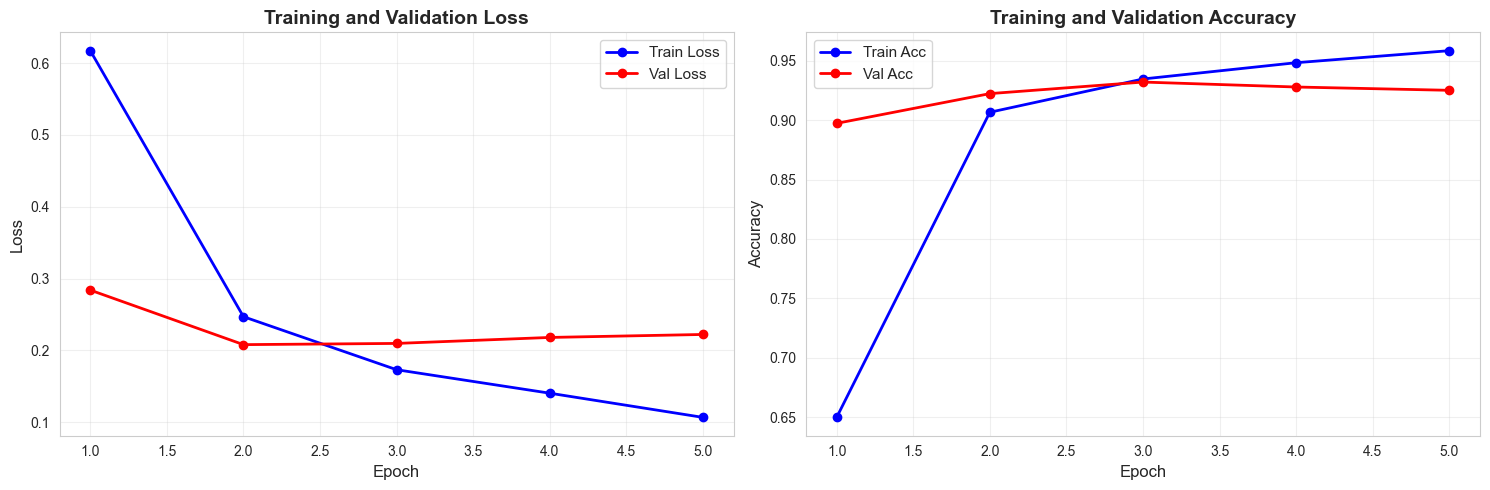

In [11]:
def plot_training_history(history, save_path):
    """
    Plot training and validation loss/accuracy curves
    """
    epochs_range = range(1, len(history['train_loss']) + 1)
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot loss
    axes[0].plot(epochs_range, history['train_loss'], 'b-o', label='Train Loss', linewidth=2)
    axes[0].plot(epochs_range, history['val_loss'], 'r-o', label='Val Loss', linewidth=2)
    axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].legend(fontsize=11)
    axes[0].grid(True, alpha=0.3)
    
    # Plot accuracy
    axes[1].plot(epochs_range, history['train_acc'], 'b-o', label='Train Acc', linewidth=2)
    axes[1].plot(epochs_range, history['val_acc'], 'r-o', label='Val Acc', linewidth=2)
    axes[1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Accuracy', fontsize=12)
    axes[1].legend(fontsize=11)
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"✓ Training curves saved to: {save_path}")
    plt.show()

# Plot training curves
history_plot_path = f"{CONFIG['output_dir']}/figures/distilbert_training_history.png"
plot_training_history(history, history_plot_path)

## 11. Evaluate on Test Set

In [16]:
print("Loading best model checkpoint...")
model.load_state_dict(torch.load(CONFIG['model_save_path'], map_location=device))
model.eval()

def get_predictions(model, dataloader, device):
    """
    Get predictions and probabilities for entire dataset
    """
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Getting predictions"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids, attention_mask)
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(outputs, dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())  # Probability of positive class
    
    return np.array(all_preds), np.array(all_labels), np.array(all_probs)

print("\nEvaluating on test set...")
y_pred, y_test, y_pred_proba = get_predictions(model, test_loader, device)

distilbert_metrics = {
    'accuracy': accuracy_score(y_test, y_pred),
    'precision': precision_score(y_test, y_pred),
    'recall': recall_score(y_test, y_pred),
    'f1_score': f1_score(y_test, y_pred),
    'cohen_kappa': cohen_kappa_score(y_test, y_pred)
}

Loading best model checkpoint...

Evaluating on test set...


Getting predictions: 100%|██████████| 38/38 [00:21<00:00,  1.75it/s]


Buscando modelo en: ../outputs/saved_models/distilbert_best.pth
Cargando datos de prueba...
✓ Pesos cargados exitosamente desde el archivo .pth
Generando predicciones...

RESULTADOS RECUPERADOS (DistilBERT)
Accuracy:      0.9317
Precision:     0.9274
Recall:        0.9367
F1 Score:      0.9320
Cohen's Kappa: 0.8633


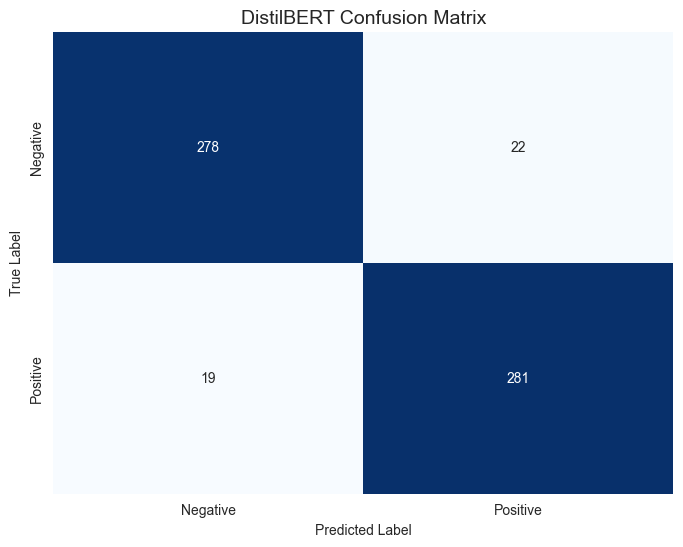

In [17]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, confusion_matrix, classification_report
from transformers import DistilBertTokenizer
from torch.utils.data import DataLoader, Dataset

# --- CONFIGURACIÓN RÁPIDA ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Ajusta esta ruta si es necesario, basándonos en tu imagen y descripción:
MODEL_PATH = '../outputs/saved_models/distilbert_best.pth'
DATA_PATH = '../data/processed/test.csv' # Asegúrate de que esta ruta a tu test.csv sea correcta

print(f"Buscando modelo en: {MODEL_PATH}")

# --- 1. CARGAR DATOS DE TEST SOLAMENTE ---
print("Cargando datos de prueba...")
test_df = pd.read_csv(DATA_PATH)
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Tokenizar
test_encodings = tokenizer(
    test_df['sentence'].tolist(),
    max_length=128,
    padding='max_length',
    truncation=True,
    return_tensors='pt'
)

# Dataset y DataLoader
class SentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __len__(self): return len(self.labels)
    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

test_dataset = SentimentDataset(test_encodings, test_df['label'].values)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# --- 2. INICIALIZAR Y CARGAR EL MODELO ---
# Debemos crear la estructura del modelo "vacía" primero
model = DistilBertForSentiment(model_name='distilbert-base-uncased', num_labels=2)

# AHORA LA MAGIA: Cargamos los pesos guardados
# map_location asegura que funcione aunque lo hayas entrenado en GPU y ahora uses CPU o viceversa
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.to(device)
model.eval() # Modo evaluación (apaga dropout, etc)
print("✓ Pesos cargados exitosamente desde el archivo .pth")

# --- 3. GENERAR PREDICCIONES ---
all_preds = []
all_labels = []

print("Generando predicciones...")
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# --- 4. CALCULAR Y MOSTRAR MÉTRICAS ---
y_test = np.array(all_labels)
y_pred = np.array(all_preds)

metrics = {
    'accuracy': accuracy_score(y_test, y_pred),
    'precision': precision_score(y_test, y_pred),
    'recall': recall_score(y_test, y_pred),
    'f1_score': f1_score(y_test, y_pred),
    'cohen_kappa': cohen_kappa_score(y_test, y_pred)
}

print("\n" + "="*60)
print("RESULTADOS RECUPERADOS (DistilBERT)")
print("="*60)
print(f"Accuracy:      {metrics['accuracy']:.4f}")
print(f"Precision:     {metrics['precision']:.4f}")
print(f"Recall:        {metrics['recall']:.4f}")
print(f"F1 Score:      {metrics['f1_score']:.4f}")
print(f"Cohen's Kappa: {metrics['cohen_kappa']:.4f}")
print("="*60)

# --- 5. GRAFICAR MATRIZ ---
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title('DistilBERT Confusion Matrix', fontsize=14)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()